# Home Credit Default Risk - Feature Engineering

**Project:** AI-Powered Intelligent Risk Management System  
**Dataset:** [Kaggle - Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk)  
**Objective:** Engineer new features from the application table, clean anomalies, and aggregate auxiliary tables into client-level predictors.

---

## Table of Contents
1. [Libraries & Configuration](#1)
2. [Data Loading](#2)
3. [Step 1 — Application Table: Derived Features](#3)
4. [Step 2 — DAYS_EMPLOYED Anomaly Cleanup](#4)
5. [Step 3 — Bureau Table Aggregations](#5)
6. [Step 4 — Previous Application Aggregations](#6)
7. [Step 5 — Installments Payments Aggregations](#7)
8. [Validation & Summary](#8)

<a id='1'></a>
## 1. Libraries & Configuration

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path for local imports
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils import reduce_memory_usage, load_dataset
from src.feature_engineering import (
    engineer_application_features,
    fix_days_employed_anomaly,
    aggregate_bureau,
    aggregate_previous_application,
    aggregate_installments,
)

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
sns.set_palette('husl')

# Pandas display
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

DATA_DIR = os.path.join(PROJECT_ROOT, 'docs', 'dataset')
PLOT_DIR = os.path.join(os.getcwd(), 'plots')
os.makedirs(PLOT_DIR, exist_ok=True)

print(f"Data directory : {DATA_DIR}")
print(f"Plot directory : {PLOT_DIR}")

Data directory : C:\Users\busra\Projects\Ai_Credit_Risk\docs\dataset
Plot directory : C:\Users\busra\Projects\Ai_Credit_Risk\notebooks\plots


<a id='2'></a>
## 2. Data Loading

For feature engineering validation we load only `application_train`  
(with 20% sampling for fast iteration).

In [2]:
# Load only the main application table for now
df = pd.read_csv(os.path.join(DATA_DIR, 'application_train.csv'))
df = df.sample(frac=0.2, random_state=42).reset_index(drop=True)
df = reduce_memory_usage(df, verbose=True)

print(f"\nShape: {df.shape}")
print(f"Columns: {df.shape[1]}")
df.head(3)

  Memory usage: 107.4 MB -> 75.7 MB (29.4% reduction)

Shape: (61502, 122)
Columns: 122


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,384575,0,Cash loans,M,Y,N,2,207000.00,465457.50,52641.00,418500.00,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.01,-13297,-762,-637.00,-4307,19.00,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,1.00,0.00,1.00
1,214010,0,Cash loans,F,Y,Y,0,247500.00,1281712.50,48946.50,1179000.00,Unaccompanied,Commercial associate,Higher education,Single / not married,House / apartment,0.01,-14778,-1141,-1610.00,-4546,11.00,1,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,1.00,0.00,3.00
2,142232,0,Cash loans,F,Y,N,0,202500.00,495000.00,39109.50,495000.00,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.04,-17907,-639,-2507.00,-1461,4.00,1,1,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,1.00,0.00,3.00


<a id='3'></a>
## 3. Step 1 — Application Table: Derived Features

We create new features purely from the application table's existing columns.
These are row-level transformations (no joins), so they run fast.

| Feature | Formula | Rationale |
|---|---|---|
| `CREDIT_INCOME_RATIO` | AMT_CREDIT / AMT_INCOME_TOTAL | Loan size relative to income — high values signal risk |
| `ANNUITY_INCOME_RATIO` | AMT_ANNUITY / AMT_INCOME_TOTAL | Monthly payment burden |
| `CREDIT_TERM` | AMT_CREDIT / AMT_ANNUITY | Estimated repayment duration (months) |
| `GOODS_CREDIT_DIFF` | AMT_GOODS_PRICE - AMT_CREDIT | Down-payment proxy — negative means over-financing |
| `INCOME_PER_CHILD` | AMT_INCOME_TOTAL / CNT_CHILDREN | Income load per dependent |
| `INCOME_PER_FAMILY` | AMT_INCOME_TOTAL / CNT_FAM_MEMBERS | Income per household member |
| `AGE_YEARS` | -DAYS_BIRTH / 365.25 | Human-readable age |
| `EMPLOYED_YEARS` | -DAYS_EMPLOYED / 365.25 | Employment tenure |
| `REGISTRATION_YEARS` | -DAYS_REGISTRATION / 365.25 | Time since ID registration |
| `HAS_CAR` | 1 if OWN_CAR_AGE is not null | Car ownership flag |

In [3]:
original_cols = df.columns.tolist()

df = engineer_application_features(df)

new_cols = [c for c in df.columns if c not in original_cols]
print(f"New features added: {len(new_cols)}")
print(f"  -> {new_cols}")
print(f"Total columns: {df.shape[1]}")

New features added: 10
  -> ['CREDIT_INCOME_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_TERM', 'GOODS_CREDIT_DIFF', 'INCOME_PER_CHILD', 'INCOME_PER_FAMILY', 'AGE_YEARS', 'EMPLOYED_YEARS', 'REGISTRATION_YEARS', 'HAS_CAR']
Total columns: 132


In [4]:
# Quick look at the new features
df[new_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
CREDIT_INCOME_RATIO,61502.00,3.95,2.67,0.00,2.02,3.27,5.15,36.69
ANNUITY_INCOME_RATIO,61500.00,0.18,0.09,0.00,0.11,0.16,0.23,1.57
CREDIT_TERM,61500.00,21.58,7.80,8.04,15.61,20.00,26.98,45.30
GOODS_CREDIT_DIFF,61448.00,-60782.33,70032.22,-445500.00,-99792.00,-39442.50,0.00,652500.00
INCOME_PER_CHILD,61502.00,160823.00,483227.03,10950.00,96750.00,135000.00,202500.00,117000000.00
INCOME_PER_FAMILY,61501.00,93694.01,173136.88,6570.00,47250.00,75000.00,112500.00,39000000.00
AGE_YEARS,61502.00,43.89,11.98,21.00,33.90,43.10,53.90,69.00
EMPLOYED_YEARS,61502.00,-174.31,386.47,-1000.00,0.80,3.30,7.60,48.00
REGISTRATION_YEARS,61502.00,13.66,9.66,0.00,5.50,12.30,20.40,67.50
HAS_CAR,61502.00,0.34,0.47,0.00,0.00,0.00,1.00,1.00


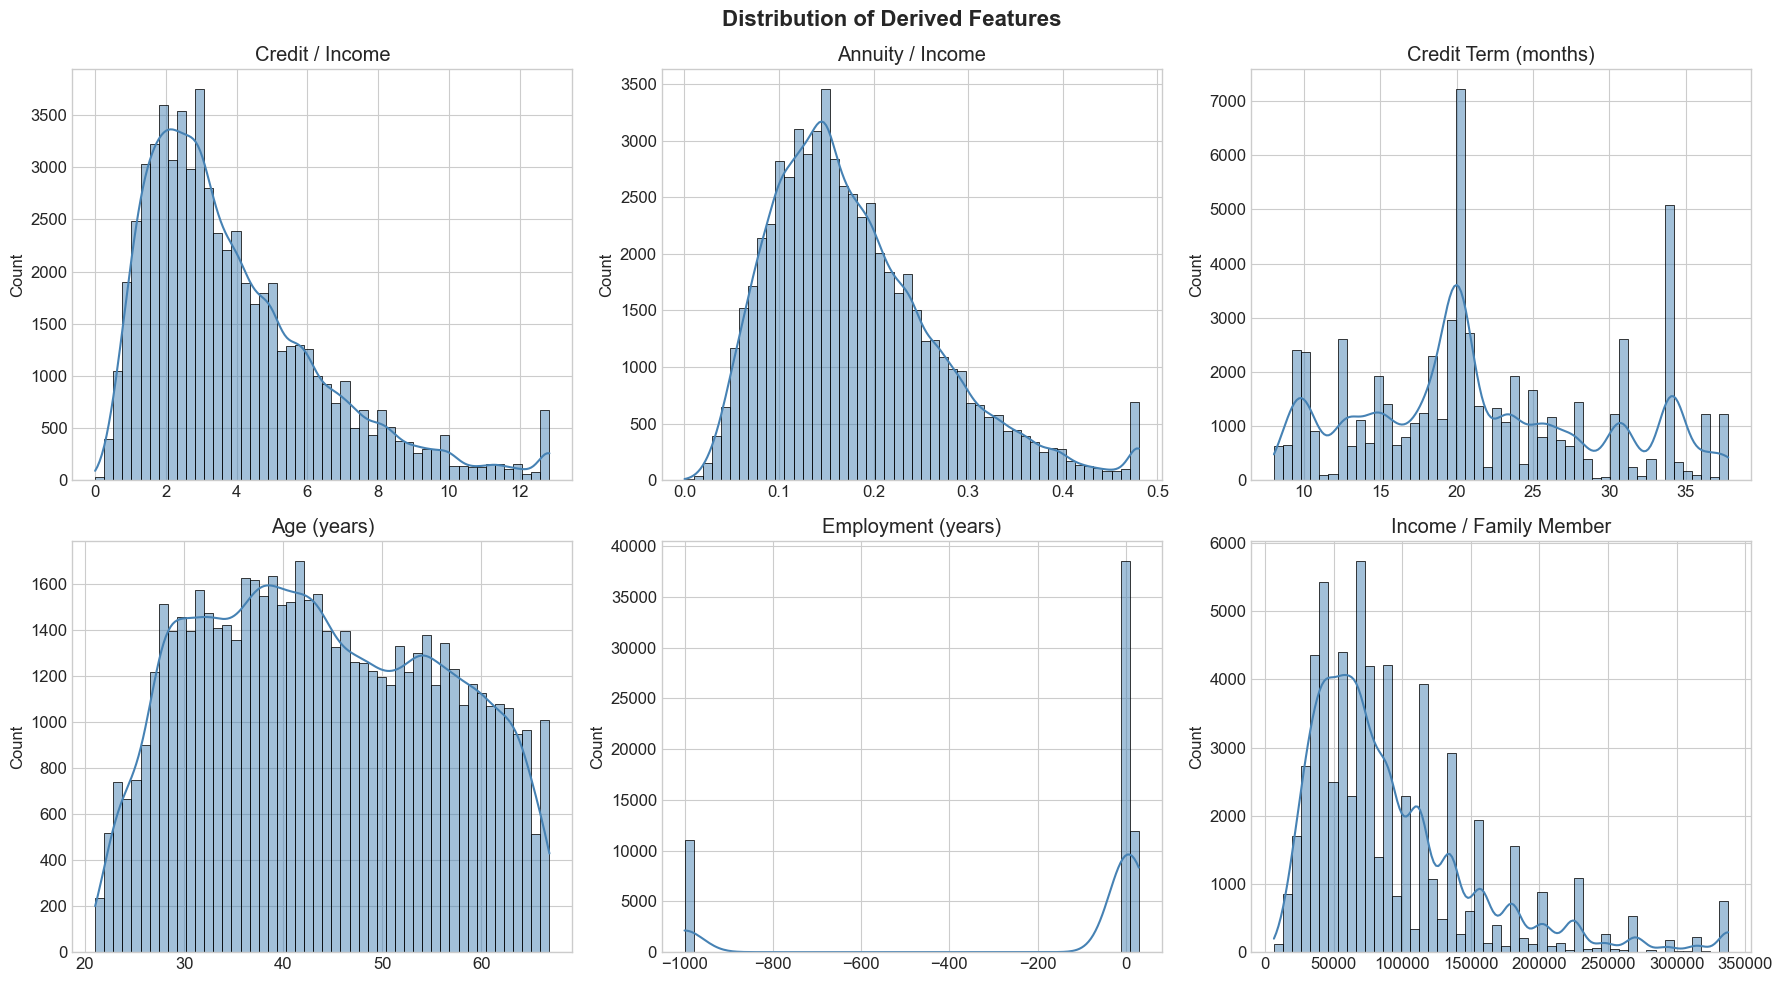

Saved: derived_features_dist.png


In [5]:
# Visualize distributions of key derived features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Derived Features', fontsize=16, fontweight='bold')

plot_features = [
    ('CREDIT_INCOME_RATIO', 'Credit / Income'),
    ('ANNUITY_INCOME_RATIO', 'Annuity / Income'),
    ('CREDIT_TERM', 'Credit Term (months)'),
    ('AGE_YEARS', 'Age (years)'),
    ('EMPLOYED_YEARS', 'Employment (years)'),
    ('INCOME_PER_FAMILY', 'Income / Family Member'),
]

for ax, (feat, title) in zip(axes.flat, plot_features):
    # Clip extreme outliers for visualization
    data = df[feat].clip(upper=df[feat].quantile(0.99))
    sns.histplot(data, ax=ax, kde=True, bins=50, color='steelblue')
    ax.set_title(title)
    ax.set_xlabel('')

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'derived_features_dist.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: derived_features_dist.png')

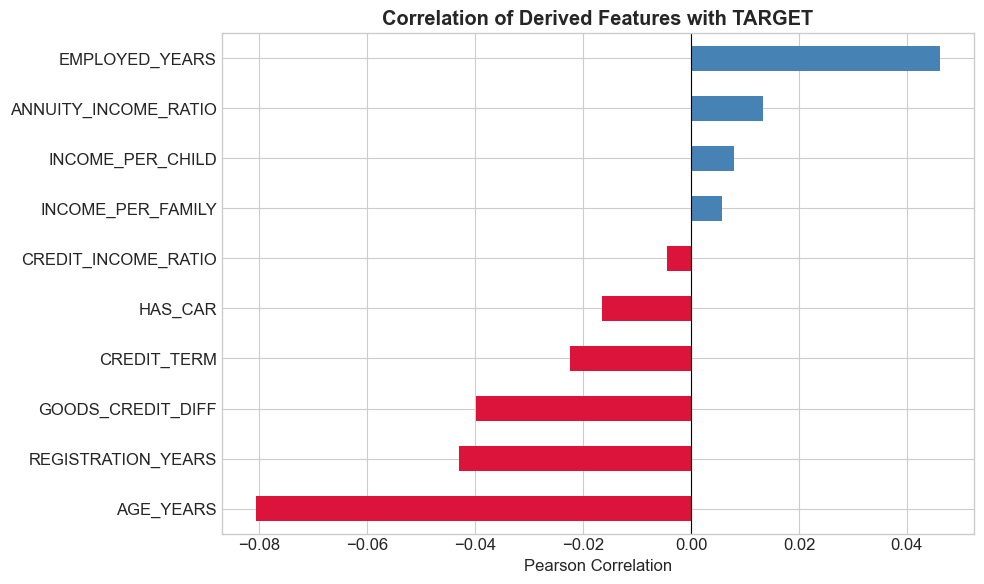

Saved: derived_features_target_corr.png


In [6]:
# Correlation of new features with TARGET
target_corr = df[['TARGET'] + new_cols].corr()['TARGET'].drop('TARGET').sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['crimson' if v < 0 else 'steelblue' for v in target_corr.values]
target_corr.plot.barh(ax=ax, color=colors)
ax.set_title('Correlation of Derived Features with TARGET', fontweight='bold')
ax.set_xlabel('Pearson Correlation')
ax.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'derived_features_target_corr.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: derived_features_target_corr.png')

<a id='4'></a>
## 4. Step 2 — DAYS_EMPLOYED Anomaly Cleanup

The EDA revealed that **DAYS_EMPLOYED** contains a sentinel value of **365,243**  
(equivalent to ~1,000 years) for clients who are not employed (retired, unemployed, etc.).  
This affects roughly **18%** of all records and will distort any model that uses this column.

**Strategy:**
1. Create a binary flag `DAYS_EMPLOYED_ANOMALY` (captures information that the value was missing).
2. Replace 365,243 with `NaN`, then fill with the median of valid records.
3. Recalculate `EMPLOYED_YEARS` after cleanup.

=== BEFORE CLEANUP ===
DAYS_EMPLOYED range : [-17522, 365243]
EMPLOYED_YEARS range: [-1000.0, 48.0]
Anomalous rows      : 11,050 (18.0%)


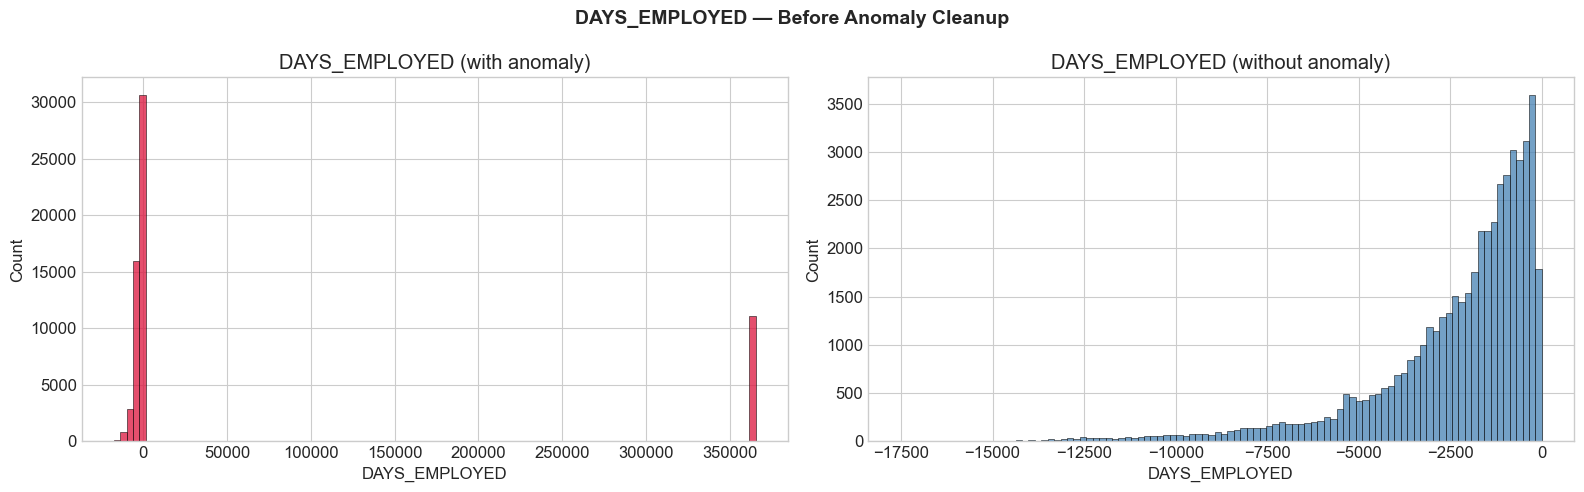

In [7]:
# Before cleanup: check the anomaly
print('=== BEFORE CLEANUP ===')
print(f"DAYS_EMPLOYED range : [{df['DAYS_EMPLOYED'].min():.0f}, {df['DAYS_EMPLOYED'].max():.0f}]")
print(f"EMPLOYED_YEARS range: [{df['EMPLOYED_YEARS'].min():.1f}, {df['EMPLOYED_YEARS'].max():.1f}]")

anomaly_mask = df['DAYS_EMPLOYED'] == 365243
print(f"Anomalous rows      : {anomaly_mask.sum():,} ({anomaly_mask.mean()*100:.1f}%)")

# Visualize BEFORE
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('DAYS_EMPLOYED — Before Anomaly Cleanup', fontsize=14, fontweight='bold')

sns.histplot(df['DAYS_EMPLOYED'], ax=axes[0], bins=100, color='crimson')
axes[0].set_title('DAYS_EMPLOYED (with anomaly)')

sns.histplot(df.loc[~anomaly_mask, 'DAYS_EMPLOYED'], ax=axes[1], bins=100, color='steelblue')
axes[1].set_title('DAYS_EMPLOYED (without anomaly)')

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'days_employed_before.png'), dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Apply the fix
df = fix_days_employed_anomaly(df)

print(f"\n=== AFTER CLEANUP ===")
print(f"DAYS_EMPLOYED range : [{df['DAYS_EMPLOYED'].min():.0f}, {df['DAYS_EMPLOYED'].max():.0f}]")
print(f"EMPLOYED_YEARS range: [{df['EMPLOYED_YEARS'].min():.1f}, {df['EMPLOYED_YEARS'].max():.1f}]")
print(f"DAYS_EMPLOYED_ANOMALY distribution:")
print(df['DAYS_EMPLOYED_ANOMALY'].value_counts())

  DAYS_EMPLOYED anomaly: 11,050 rows (18.0%) replaced with NaN
  DAYS_EMPLOYED NaN filled with median: -1653 days

=== AFTER CLEANUP ===
DAYS_EMPLOYED range : [-17522, -2]
EMPLOYED_YEARS range: [0.0, 48.0]
DAYS_EMPLOYED_ANOMALY distribution:
DAYS_EMPLOYED_ANOMALY
0    50452
1    11050
Name: count, dtype: int64


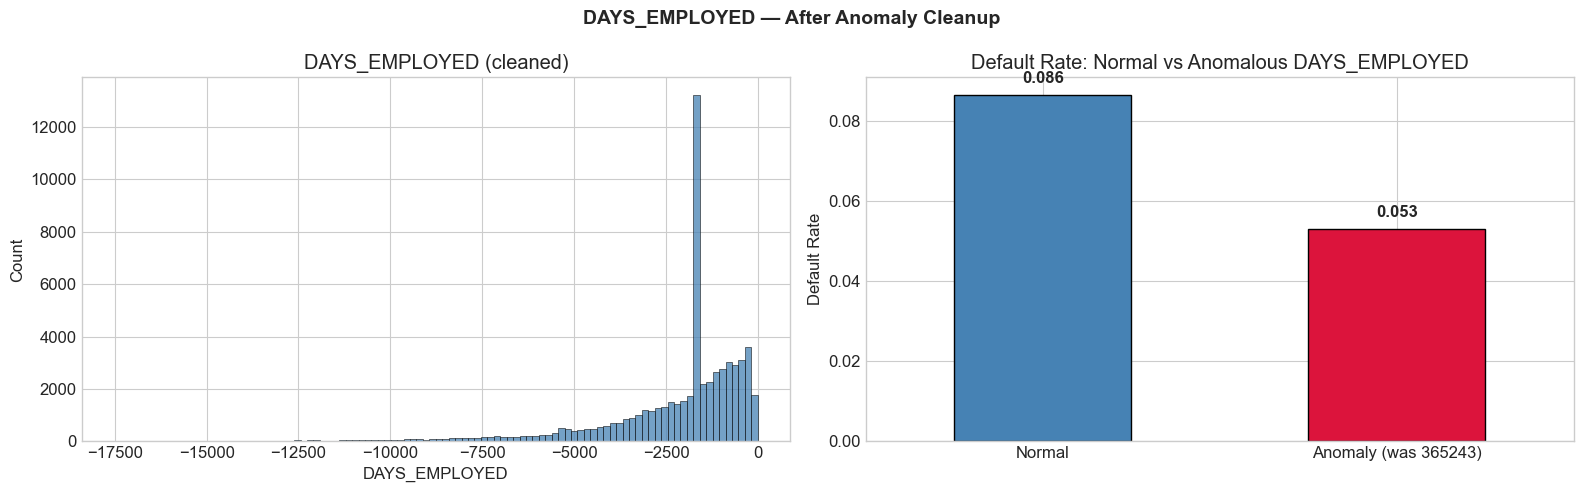

Saved: days_employed_before.png, days_employed_after.png


In [9]:
# Visualize AFTER
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('DAYS_EMPLOYED — After Anomaly Cleanup', fontsize=14, fontweight='bold')

sns.histplot(df['DAYS_EMPLOYED'], ax=axes[0], bins=100, color='steelblue')
axes[0].set_title('DAYS_EMPLOYED (cleaned)')

# Compare default rates: anomalous vs normal
anomaly_rates = df.groupby('DAYS_EMPLOYED_ANOMALY')['TARGET'].mean()
anomaly_rates.index = ['Normal', 'Anomaly (was 365243)']
anomaly_rates.plot.bar(ax=axes[1], color=['steelblue', 'crimson'], edgecolor='black')
axes[1].set_title('Default Rate: Normal vs Anomalous DAYS_EMPLOYED')
axes[1].set_ylabel('Default Rate')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

for i, v in enumerate(anomaly_rates.values):
    axes[1].text(i, v + 0.003, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'days_employed_after.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: days_employed_before.png, days_employed_after.png')

<a id='5'></a>
## 5. Step 3 — Bureau Table Aggregations

The **bureau** table contains records of a client's credit history at **other financial institutions** (banks, microfinance, etc.), reported to a credit bureau. Each row is one external credit; a single client can have dozens.

**Why aggregate?** A client who already has 10 overdue credits elsewhere is very different from someone with a clean external record — even if their Home Credit application looks identical. By collapsing the bureau table to one row per client, we capture this external risk profile.

Key signals we extract:
- **Credit count & active ratio** — how many external credits, and how many are still open
- **Overdue indicators** — max/mean overdue days, binary "has any overdue" flag
- **Credit & debt totals** — total amount borrowed externally, outstanding debt, leverage ratio
- **Timing** — how recently they opened external credits

In [10]:
# Load bureau table (full data, no sampling — we aggregate it down)
bureau = pd.read_csv(os.path.join(DATA_DIR, 'bureau.csv'))
bureau = reduce_memory_usage(bureau, verbose=True)

# Filter to only clients in our sampled train set
train_ids = set(df['SK_ID_CURR'].unique())
bureau = bureau[bureau['SK_ID_CURR'].isin(train_ids)].reset_index(drop=True)
print(f"\nBureau rows (filtered): {len(bureau):,}")
print(f"Unique clients in bureau: {bureau['SK_ID_CURR'].nunique():,}")
print(f"Clients in train with NO bureau record: {len(train_ids) - bureau['SK_ID_CURR'].nunique():,}")

  Memory usage: 512.1 MB -> 409.0 MB (20.1% reduction)

Bureau rows (filtered): 291,947
Unique clients in bureau: 52,682
Clients in train with NO bureau record: 8,820


In [11]:
# Aggregate bureau to one row per client
bureau_agg = aggregate_bureau(bureau)
print(f"\nBureau aggregated shape: {bureau_agg.shape}")
print(f"Columns: {list(bureau_agg.columns)}")
bureau_agg.head()

  Bureau aggregation: 16 features for 52,682 clients

Bureau aggregated shape: (52682, 17)
Columns: ['SK_ID_CURR', 'BUREAU_CREDIT_COUNT', 'BUREAU_OVERDUE_MAX', 'BUREAU_OVERDUE_MEAN', 'BUREAU_CREDIT_SUM_TOTAL', 'BUREAU_CREDIT_SUM_MEAN', 'BUREAU_CREDIT_SUM_MAX', 'BUREAU_DEBT_SUM_TOTAL', 'BUREAU_OVERDUE_CREDIT_SUM', 'BUREAU_DAYS_CREDIT_MEAN', 'BUREAU_DAYS_CREDIT_MIN', 'BUREAU_PROLONGATION_SUM', 'BUREAU_ACTIVE_COUNT', 'BUREAU_CLOSED_COUNT', 'BUREAU_ACTIVE_RATIO', 'BUREAU_DEBT_CREDIT_RATIO', 'BUREAU_HAS_OVERDUE']


,SK_ID_CURR,BUREAU_CREDIT_COUNT,BUREAU_OVERDUE_MAX,BUREAU_OVERDUE_MEAN,BUREAU_CREDIT_SUM_TOTAL,BUREAU_CREDIT_SUM_MEAN,BUREAU_CREDIT_SUM_MAX,BUREAU_DEBT_SUM_TOTAL,BUREAU_OVERDUE_CREDIT_SUM,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_MIN,BUREAU_PROLONGATION_SUM,BUREAU_ACTIVE_COUNT,BUREAU_CLOSED_COUNT,BUREAU_ACTIVE_RATIO,BUREAU_DEBT_CREDIT_RATIO,BUREAU_HAS_OVERDUE
0,100002,8,0,0.00,865055.56,108131.95,450000.00,245781.00,0.00,-874.00,-1437,0,2,6,0.25,0.28,0
1,100004,2,0,0.00,189037.80,94518.90,94537.80,0.00,0.00,-867.00,-1326,0,0,2,0.00,0.00,0
2,100009,18,0,0.00,4800811.50,266711.75,1777500.00,1077349.50,0.00,-1271.50,-2882,0,4,14,0.22,0.22,0
3,100015,4,0,0.00,409495.50,102373.88,131103.00,0.00,0.00,-947.75,-1409,0,0,4,0.00,0.00,0
4,100016,7,0,0.00,474984.00,67854.86,91264.50,63724.50,0.00,-618.43,-1634,0,4,3,0.57,0.13,0


In [12]:
# Merge bureau features into the main table
df = df.merge(bureau_agg, on='SK_ID_CURR', how='left')

# Clients with no bureau record will have NaN — fill with 0 for count/flag columns
bureau_fill_zero = [c for c in bureau_agg.columns if c != 'SK_ID_CURR' and
                    any(k in c for k in ['COUNT', 'HAS_', 'SUM', 'PROLONGATION'])]
df[bureau_fill_zero] = df[bureau_fill_zero].fillna(0)

print(f"Shape after bureau merge: {df.shape}")
print(f"Bureau features NaN remaining: {df[[c for c in bureau_agg.columns if c != 'SK_ID_CURR']].isnull().sum().sum()}")

Shape after bureau merge: (61502, 149)
Bureau features NaN remaining: 52920


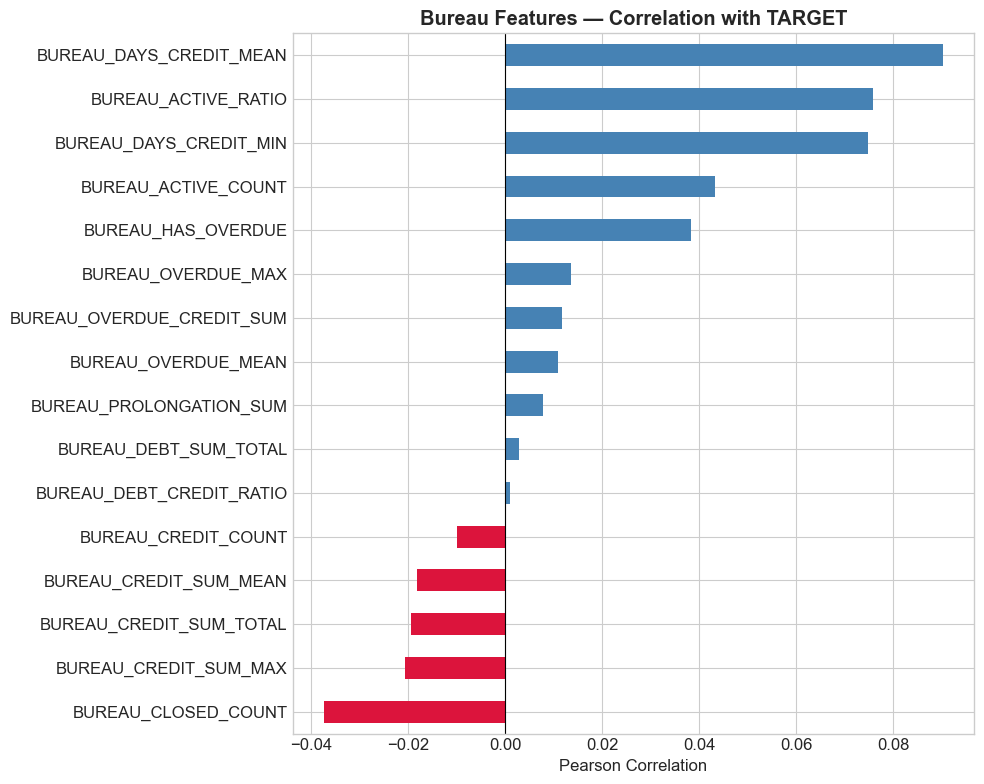

Saved: bureau_target_corr.png


In [13]:
# Visualize bureau features: correlation with TARGET
bureau_feat_cols = [c for c in bureau_agg.columns if c != 'SK_ID_CURR']
bureau_corr = df[['TARGET'] + bureau_feat_cols].corr()['TARGET'].drop('TARGET').sort_values()

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['crimson' if v < 0 else 'steelblue' for v in bureau_corr.values]
bureau_corr.plot.barh(ax=ax, color=colors)
ax.set_title('Bureau Features — Correlation with TARGET', fontweight='bold')
ax.set_xlabel('Pearson Correlation')
ax.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'bureau_target_corr.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: bureau_target_corr.png')

<a id='6'></a>
## 6. Step 4 — Previous Application Aggregations

The **previous_application** table records every past loan application the client made **at Home Credit**. Unlike bureau (external history), this is Home Credit's own memory of the client.

**Why aggregate?** A client who was rejected 5 times before finally getting approved is a fundamentally different risk profile from a first-time applicant. The approval-to-rejection ratio, the size of past loans relative to the current one, and how recently they last applied all carry predictive signal.

Key signals we extract:
- **Application & approval counts** — total past applications, how many approved vs refused
- **Approval rate** — the single most telling ratio from this table
- **Financial patterns** — average/max amounts requested vs granted, down payment behavior
- **Cash loan ratio** — proportion of cash loans (vs revolving), indicating loan purpose
- **Recency** — how recently the client last interacted with Home Credit

In [14]:
# Load previous_application table
prev = pd.read_csv(os.path.join(DATA_DIR, 'previous_application.csv'))
prev = reduce_memory_usage(prev, verbose=True)

# Filter to sampled train clients
prev = prev[prev['SK_ID_CURR'].isin(train_ids)].reset_index(drop=True)
print(f"\nPrevious application rows (filtered): {len(prev):,}")
print(f"Unique clients: {prev['SK_ID_CURR'].nunique():,}")
print(f"Clients with NO previous application: {len(train_ids) - prev['SK_ID_CURR'].nunique():,}")

  Memory usage: 1900.6 MB -> 1754.1 MB (7.7% reduction)



Previous application rows (filtered): 282,810
Unique clients: 58,231
Clients with NO previous application: 3,271


In [15]:
# Aggregate to one row per client
prev_agg = aggregate_previous_application(prev)
print(f"\nPrevious application aggregated shape: {prev_agg.shape}")
print(f"Columns: {list(prev_agg.columns)}")
prev_agg.head()

  Previous application aggregation: 14 features for 58,231 clients

Previous application aggregated shape: (58231, 15)
Columns: ['SK_ID_CURR', 'PREV_APP_COUNT', 'PREV_AMT_APPLICATION_MEAN', 'PREV_AMT_APPLICATION_MAX', 'PREV_AMT_CREDIT_MEAN', 'PREV_AMT_CREDIT_MAX', 'PREV_AMT_DOWN_PAYMENT_MEAN', 'PREV_DAYS_DECISION_MEAN', 'PREV_DAYS_DECISION_MIN', 'PREV_CNT_PAYMENT_MEAN', 'PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT', 'PREV_CASH_LOAN_RATIO', 'PREV_APPROVAL_RATE', 'PREV_APP_CREDIT_DIFF_MEAN']


,SK_ID_CURR,PREV_APP_COUNT,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_DAYS_DECISION_MEAN,PREV_DAYS_DECISION_MIN,PREV_CNT_PAYMENT_MEAN,PREV_APPROVED_COUNT,PREV_REFUSED_COUNT,PREV_CASH_LOAN_RATIO,PREV_APPROVAL_RATE,PREV_APP_CREDIT_DIFF_MEAN
0,100002,1,179055.00,179055.00,179055.00,179055.00,0.00,-606.00,-606,24.00,1,0,0.00,1.00,0.00
1,100004,1,24282.00,24282.00,20106.00,20106.00,4860.00,-815.00,-815,4.00,1,0,0.00,1.00,4176.00
2,100009,7,76741.71,110160.00,70137.64,98239.50,9203.14,-719.29,-1562,8.00,7,0,0.00,1.00,6604.07
3,100015,1,68850.00,68850.00,67077.00,67077.00,6885.00,-2396.00,-2396,10.00,1,0,0.00,1.00,1773.00
4,100016,4,120745.12,290250.00,106221.38,232200.00,15690.38,-1779.50,-2370,17.00,4,0,0.00,1.00,14523.75


In [16]:
# Merge previous application features into the main table
df = df.merge(prev_agg, on='SK_ID_CURR', how='left')

# Clients with no previous application -> fill counts with 0
prev_fill_zero = [c for c in prev_agg.columns if c != 'SK_ID_CURR' and
                  any(k in c for k in ['COUNT', 'RATE'])]
df[prev_fill_zero] = df[prev_fill_zero].fillna(0)

print(f"Shape after previous application merge: {df.shape}")
print(f"Prev features NaN remaining: {df[[c for c in prev_agg.columns if c != 'SK_ID_CURR']].isnull().sum().sum()}")

Shape after previous application merge: (61502, 163)
Prev features NaN remaining: 36362


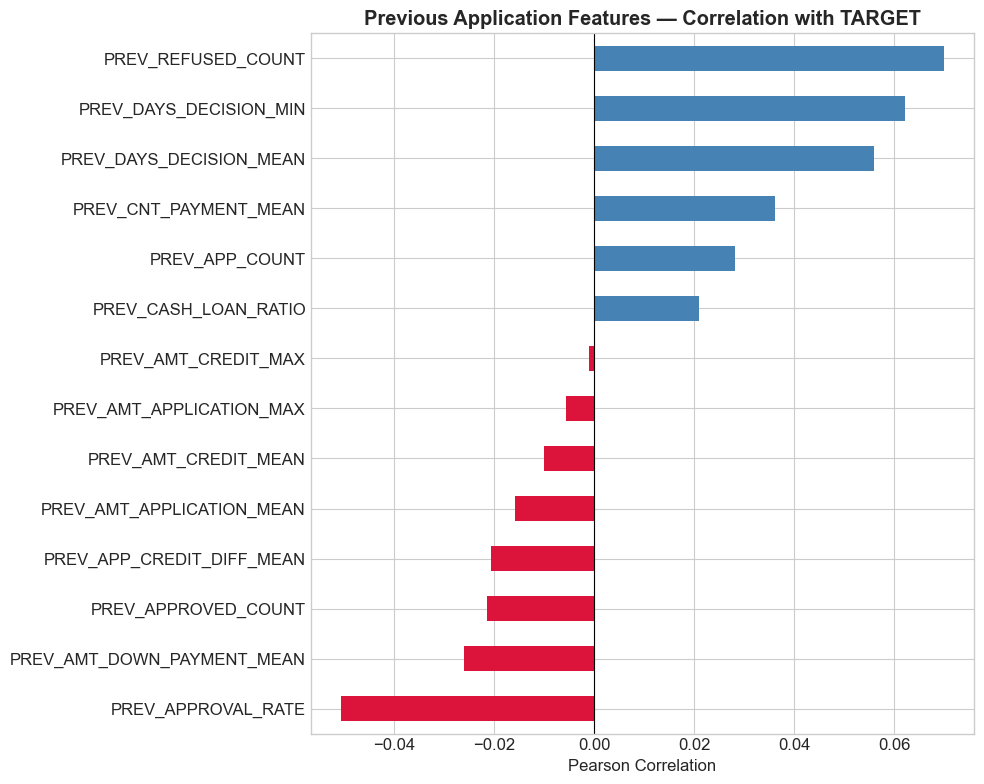

Saved: prev_app_target_corr.png


In [17]:
# Visualize previous application features: correlation with TARGET
prev_feat_cols = [c for c in prev_agg.columns if c != 'SK_ID_CURR']
prev_corr = df[['TARGET'] + prev_feat_cols].corr()['TARGET'].drop('TARGET').sort_values()

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['crimson' if v < 0 else 'steelblue' for v in prev_corr.values]
prev_corr.plot.barh(ax=ax, color=colors)
ax.set_title('Previous Application Features — Correlation with TARGET', fontweight='bold')
ax.set_xlabel('Pearson Correlation')
ax.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'prev_app_target_corr.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: prev_app_target_corr.png')

<a id='7'></a>
## 7. Step 5 — Installments Payments Aggregations

The **installments_payments** table is arguably the **most valuable** table in this dataset. While bureau tells us *what credits* a client has and previous_application tells us *what they applied for*, this table tells us **how they actually paid** — the ground truth of repayment behavior.

Each row represents a single scheduled payment: when it was due, when the client actually paid, how much was due, and how much they actually paid. By comparing "scheduled vs actual" on both dimensions (time and amount), we derive two critical signals:

- **DPD (Days Past Due):** `actual_date - scheduled_date`. Positive means the client paid late.
- **Payment Difference:** `actual_amount - scheduled_amount`. Negative means the client underpaid.

These two signals — lateness and underpayment — are the most direct behavioral predictors of future default.

In [18]:
# Load installments_payments table (13.6M rows — largest table)
inst = pd.read_csv(os.path.join(DATA_DIR, 'installments_payments.csv'))
inst = reduce_memory_usage(inst, verbose=True)

# Filter to sampled train clients
inst = inst[inst['SK_ID_CURR'].isin(train_ids)].reset_index(drop=True)
print(f"\nInstallments rows (filtered): {len(inst):,}")
print(f"Unique clients: {inst['SK_ID_CURR'].nunique():,}")
print(f"Clients with NO installment record: {len(train_ids) - inst['SK_ID_CURR'].nunique():,}")
print(f"Average payments per client: {len(inst) / inst['SK_ID_CURR'].nunique():.1f}")

  Memory usage: 830.4 MB -> 389.3 MB (53.1% reduction)



Installments rows (filtered): 2,313,225
Unique clients: 58,335
Clients with NO installment record: 3,167
Average payments per client: 39.7


In [19]:
# Aggregate to one row per client
inst_agg = aggregate_installments(inst)
print(f"\nInstallments aggregated shape: {inst_agg.shape}")
print(f"Columns: {list(inst_agg.columns)}")
inst_agg.describe().T

  Installments aggregation: 14 features for 58,335 clients

Installments aggregated shape: (58335, 15)
Columns: ['SK_ID_CURR', 'INST_PAYMENT_COUNT', 'INST_DPD_MEAN', 'INST_DPD_MAX', 'INST_DPD_SUM', 'INST_LATE_COUNT', 'INST_LATE_RATIO', 'INST_PAYMENT_DIFF_MEAN', 'INST_PAYMENT_DIFF_MIN', 'INST_UNDERPAID_COUNT', 'INST_UNDERPAID_RATIO', 'INST_AMT_PAYMENT_MEAN', 'INST_AMT_PAYMENT_SUM', 'INST_AMT_INSTALMENT_SUM', 'INST_PAYMENT_FULFILLMENT']


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,58335.00,277831.01,102632.33,100002.00,189230.50,277612.00,366519.00,456247.00
INST_PAYMENT_COUNT,58335.00,39.65,40.25,1.00,12.00,25.00,51.00,372.00
INST_DPD_MEAN,58332.00,1.11,11.28,0.00,0.00,0.04,0.51,1885.39
INST_DPD_MAX,58332.00,18.63,112.45,0.00,0.00,1.00,9.00,2882.00
INST_DPD_SUM,58335.00,44.20,441.43,0.00,0.00,1.00,21.00,82957.00
INST_LATE_COUNT,58335.00,3.40,6.40,0.00,0.00,1.00,4.00,159.00
INST_LATE_RATIO,58335.00,0.08,0.12,0.00,0.00,0.02,0.11,1.00
INST_PAYMENT_DIFF_MEAN,58332.00,361.11,5287.11,-146145.89,-446.12,0.00,0.00,337496.81
INST_PAYMENT_DIFF_MIN,58332.00,-6672.17,13003.44,-490957.59,-9000.00,0.00,0.00,7319.07
INST_UNDERPAID_COUNT,58335.00,3.77,7.88,0.00,0.00,0.00,4.00,129.00


In [20]:
# Merge installment features into the main table
df = df.merge(inst_agg, on='SK_ID_CURR', how='left')

# Clients with no installment records -> fill counts and ratios with 0
inst_fill_zero = [c for c in inst_agg.columns if c != 'SK_ID_CURR' and
                  any(k in c for k in ['COUNT', 'RATIO', 'SUM', 'LATE', 'UNDERPAID'])]
df[inst_fill_zero] = df[inst_fill_zero].fillna(0)

print(f"Shape after installments merge: {df.shape}")
print(f"Installment features NaN remaining: {df[[c for c in inst_agg.columns if c != 'SK_ID_CURR']].isnull().sum().sum()}")

Shape after installments merge: (61502, 177)
Installment features NaN remaining: 19017


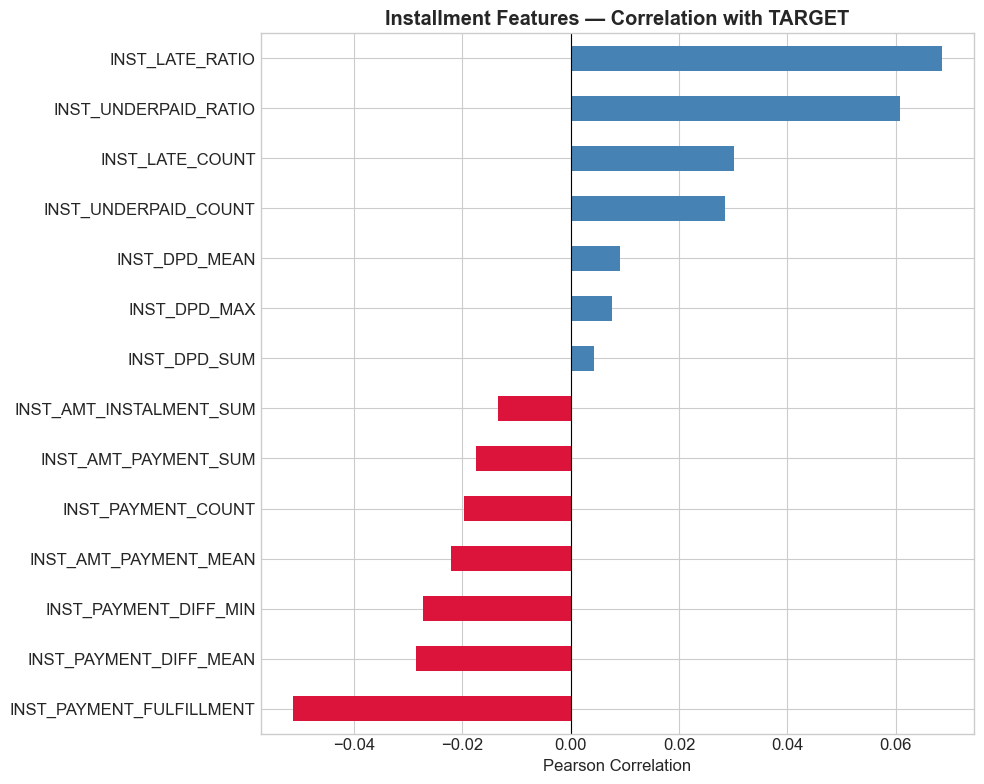

Saved: installments_target_corr.png


In [21]:
# Visualize installment features: correlation with TARGET
inst_feat_cols = [c for c in inst_agg.columns if c != 'SK_ID_CURR']
inst_corr = df[['TARGET'] + inst_feat_cols].corr()['TARGET'].drop('TARGET').sort_values()

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['crimson' if v < 0 else 'steelblue' for v in inst_corr.values]
inst_corr.plot.barh(ax=ax, color=colors)
ax.set_title('Installment Features — Correlation with TARGET', fontweight='bold')
ax.set_xlabel('Pearson Correlation')
ax.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'installments_target_corr.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: installments_target_corr.png')

<a id='8'></a>
## 8. Validation & Summary

In [22]:
# Final summary of all engineered features
app_new = new_cols + ['DAYS_EMPLOYED_ANOMALY']
bureau_new = [c for c in bureau_agg.columns if c != 'SK_ID_CURR']
prev_new = [c for c in prev_agg.columns if c != 'SK_ID_CURR']
inst_new = [c for c in inst_agg.columns if c != 'SK_ID_CURR']
all_engineered = app_new + bureau_new + prev_new + inst_new

print(f'=== FEATURE ENGINEERING SUMMARY ===')
print(f'  Step 1 — Application derived   : {len(new_cols)} features')
print(f'  Step 2 — DAYS_EMPLOYED cleanup  : 1 flag + column fix')
print(f'  Step 3 — Bureau aggregations    : {len(bureau_new)} features')
print(f'  Step 4 — Previous app agg.      : {len(prev_new)} features')
print(f'  Step 5 — Installments agg.      : {len(inst_new)} features')
print(f'  ─────────────────────────────────')
print(f'  Total new features              : {len(all_engineered)}')
print(f'  Total columns now               : {df.shape[1]}')
print(f'  Shape                           : {df.shape}')
print()

# Check remaining NaN in engineered features
nan_check = df[all_engineered].isnull().sum()
nan_check = nan_check[nan_check > 0]
if len(nan_check) == 0:
    print('No NaN values in any engineered feature.')
else:
    print(f'NaN values remaining ({len(nan_check)} columns):')
    print(nan_check.sort_values(ascending=False))

print()
print('--- Engineered Features Statistics ---')
df[all_engineered].describe().T

=== FEATURE ENGINEERING SUMMARY ===
  Step 1 — Application derived   : 10 features
  Step 2 — DAYS_EMPLOYED cleanup  : 1 flag + column fix
  Step 3 — Bureau aggregations    : 16 features
  Step 4 — Previous app agg.      : 14 features
  Step 5 — Installments agg.      : 14 features
  ─────────────────────────────────
  Total new features              : 55
  Total columns now               : 177
  Shape                           : (61502, 177)

NaN values remaining (26 columns):
BUREAU_OVERDUE_MAX            8820
BUREAU_OVERDUE_MEAN           8820
BUREAU_DAYS_CREDIT_MEAN       8820
BUREAU_DAYS_CREDIT_MIN        8820
BUREAU_ACTIVE_RATIO           8820
BUREAU_DEBT_CREDIT_RATIO      8820
PREV_AMT_DOWN_PAYMENT_MEAN    6835
PREV_CNT_PAYMENT_MEAN         3359
PREV_AMT_CREDIT_MAX           3271
PREV_APP_CREDIT_DIFF_MEAN     3271
PREV_CASH_LOAN_RATIO          3271
PREV_DAYS_DECISION_MIN        3271
PREV_DAYS_DECISION_MEAN       3271
PREV_AMT_APPLICATION_MEAN     3271
PREV_AMT_CREDIT_MEAN       

,count,mean,std,min,25%,50%,75%,max
CREDIT_INCOME_RATIO,61502.00,3.95,2.67,0.00,2.02,3.27,5.15,36.69
ANNUITY_INCOME_RATIO,61500.00,0.18,0.09,0.00,0.11,0.16,0.23,1.57
CREDIT_TERM,61500.00,21.58,7.80,8.04,15.61,20.00,26.98,45.30
GOODS_CREDIT_DIFF,61448.00,-60782.33,70032.22,-445500.00,-99792.00,-39442.50,0.00,652500.00
INCOME_PER_CHILD,61502.00,160823.00,483227.03,10950.00,96750.00,135000.00,202500.00,117000000.00
INCOME_PER_FAMILY,61501.00,93694.01,173136.88,6570.00,47250.00,75000.00,112500.00,39000000.00
AGE_YEARS,61502.00,43.89,11.98,21.00,33.90,43.10,53.90,69.00
EMPLOYED_YEARS,61502.00,6.17,5.84,0.00,2.60,4.50,7.60,48.00
REGISTRATION_YEARS,61502.00,13.66,9.66,0.00,5.50,12.30,20.40,67.50
HAS_CAR,61502.00,0.34,0.47,0.00,0.00,0.00,1.00,1.00


### Key Observations

**Step 1 — Derived Features:**
- `CREDIT_INCOME_RATIO` and `ANNUITY_INCOME_RATIO` capture financial burden and are expected to be strong predictors.
- `CREDIT_TERM` shows the estimated loan duration; very long terms may indicate higher risk.
- `GOODS_CREDIT_DIFF` reveals whether clients are financing more than the goods price (negative = over-financing).
- `HAS_CAR` is a clean binary feature derived from a mostly-null `OWN_CAR_AGE` column.

**Step 2 — DAYS_EMPLOYED Anomaly:**
- ~18% of records had the sentinel value 365,243 — now flagged in `DAYS_EMPLOYED_ANOMALY`.
- This flag itself may be predictive: anomalous clients could have a different default profile.
- After median imputation, `EMPLOYED_YEARS` has a realistic distribution.

**Step 3 — Bureau Aggregations:**
- External credit history condensed to ~16 features per client.
- `BUREAU_HAS_OVERDUE` and `BUREAU_DEBT_CREDIT_RATIO` are expected to be strong default signals.
- Some clients have no bureau record — their values are filled with 0 for count/flag columns, NaN for amounts/ratios (will be handled during preprocessing).

**Step 4 — Previous Application Aggregations:**
- Past Home Credit interactions condensed to ~14 features per client.
- `PREV_APPROVAL_RATE` is a key feature: clients with low approval history may be riskier.
- `PREV_APP_CREDIT_DIFF_MEAN` reveals systematic gaps between what clients request and what they receive.

**Step 5 — Installments Payments Aggregations:**
- Actual repayment behavior condensed to ~14 features per client.
- `INST_LATE_RATIO` and `INST_DPD_MEAN` are the most direct behavioral predictors of default.
- `INST_PAYMENT_FULFILLMENT` (total paid / total due) captures whether a client systematically underpays.
- This is the strongest behavioral signal source — all other tables describe *applications*, this one describes *actions*.

---

### Next Steps

- **Step 6:** Credit card balance & POS_CASH_balance aggregations
- **Step 7:** Merge all features into a single training DataFrame and save to disk